# Binary Tree of Languages
an exercise in hierarchical clustering

In [1]:
import pandas as pd
from statistics import mean
import seaborn as sns
from itertools import product

In [2]:
df = pd.read_csv("languages.csv")
df = df.applymap(str.lower)  # convert to lowercase
df.head()

,English,German,French,Portuguese,Spanish,Polish,Catalan,Russian,Greek,Georgian,Finnish,Albanian,Arabic
0,house,haus,maison,casa,casa,dom,casa,dom,spiti,sakhli,talo,shtëpi,beit
1,mother,mutter,mère,mãe,madre,matka,mare,mat',mhtera,deda,aiti,mama,um
2,human,mensch,humain,humano,humano,czlowiek,humà,chelovek,anthropos,adamiani,ihminen,njeri,insan
3,school,schule,école,escola,colegio/ escuela,szkola,escola,shkola,sxoleio,skola,koulu,shkoll,madrasah
4,friendship,freundschaft,amitié,amizade,amistad,przyjacielstwo,amistat,drujba,filia,megobroba,ystavyys,shoqëri,sadaqah


In [3]:
df.shape  # rows, cols

(26, 13)

### Calculate Word Similarity

In [4]:
def calc_word_similarity(word1: str, word2: str) -> float:
    """returns the similarity of two words between 0 and 1"""
    s1, s2 = set(word1), set(word2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [5]:
# test code
assert calc_word_similarity("hello", "hello") == 1.0
assert calc_word_similarity("home", "dome") == 0.6
assert calc_word_similarity("spam", "eggs") == 1 / 6

### Calculate Language Similarity

In [6]:
def calc_language_similarity(words1, words2) -> float:
    return mean(
        calc_word_similarity(w1, w2)
        for w1, w2 in zip(words1, words2)
    )

In [7]:
calc_language_similarity(df["Russian"], df["English"])

0.2889639740601279

### Calculate a Similarity Matrix

In [8]:
languages = df.columns
sims = [
    [
        calc_language_similarity(df[lang1], df[lang2])
        for lang2 in languages
    ]
    for lang1 in languages
]

sim_matrix = pd.DataFrame(sims, index=languages, columns=languages)
sim_matrix.round(2)

,English,German,French,Portuguese,Spanish,Polish,Catalan,Russian,Greek,Georgian,Finnish,Albanian,Arabic
English,1.00,0.41,0.42,0.39,0.39,0.27,0.38,0.29,0.33,0.30,0.20,0.30,0.18
German,0.41,1.00,0.28,0.33,0.30,0.28,0.29,0.28,0.30,0.26,0.22,0.35,0.19
French,0.42,0.28,1.00,0.50,0.49,0.23,0.52,0.21,0.31,0.28,0.24,0.30,0.15
Portuguese,0.39,0.33,0.50,1.00,0.63,0.26,0.55,0.28,0.34,0.27,0.22,0.32,0.20
Spanish,0.39,0.30,0.49,0.63,1.00,0.28,0.62,0.28,0.33,0.27,0.20,0.32,0.17
Polish,0.27,0.28,0.23,0.26,0.28,1.00,0.26,0.58,0.28,0.31,0.26,0.35,0.18
Catalan,0.38,0.29,0.52,0.55,0.62,0.26,1.00,0.25,0.29,0.27,0.20,0.30,0.18
Russian,0.29,0.28,0.21,0.28,0.28,0.58,0.25,1.00,0.31,0.31,0.28,0.34,0.19
Greek,0.33,0.30,0.31,0.34,0.33,0.28,0.29,0.31,1.00,0.27,0.25,0.34,0.24
Georgian,0.30,0.26,0.28,0.27,0.27,0.31,0.27,0.31,0.27,1.00,0.28,0.31,0.24


<AxesSubplot: >

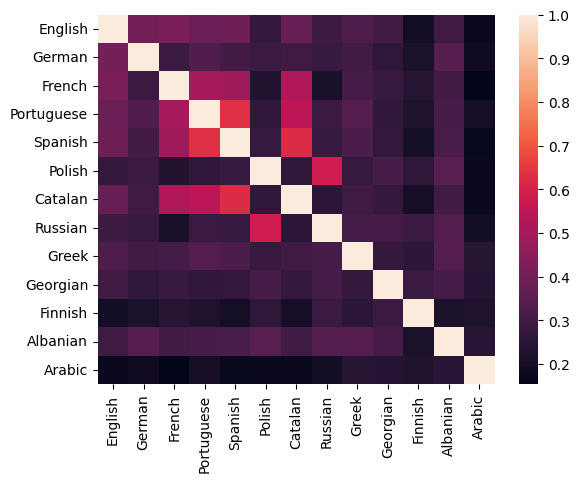

In [9]:
sns.heatmap(sim_matrix)

### Hierarchical Clustering

1. create a list of leaf nodes E from all elements you want to cluster
2. find the pair of most similar elements (e1, e2) in E
3. create a new internal node that contains e1 and e2
4. add the new node to E
5. remove e1 and e2 from E
6. repeat from step 2. until there is only one node in E

In [10]:
def get_similarity(node1, node2) -> float:
    """recursively calculate node similarity"""
    if isinstance(node1, list):
        # linkage rule: mean of two branches
        return (
            get_similarity(node1[0], node2) +
            get_similarity(node1[1], node2)
        ) / 2
    elif isinstance(node2, list):
        return get_similarity(node2, node1)
    else:
        # both are leaf nodes: look up similarity
        return sim_matrix.loc[node1, node2]

In [11]:
def find_most_similar_pair(nodes):
    similarities = []
    for i, n1 in enumerate(nodes, start=1):
        for n2 in nodes[i:]:  # only consider one triangle of matrix
            sim = get_similarity(n1, n2)
            similarities.append((sim, n1, n2))
    similarities.sort(reverse=True)
    return similarities[0]

In [12]:
# core algorithm
nodes = list(df.columns)

while len(nodes) > 1:
    sim, n1, n2 = find_most_similar_pair(nodes)
    nodes.append([n1, n2])
    nodes.remove(n1)
    nodes.remove(n2)

print(nodes)

[['Arabic', [[[['French', ['Catalan', ['Portuguese', 'Spanish']]], ['English', 'German']], ['Greek', ['Albanian', ['Polish', 'Russian']]]], ['Georgian', 'Finnish']]]]


### Use Graphviz to draw a tree on screen

In [13]:
def draw_tree(node, graph):
    if isinstance(node, list):
        draw_tree(node[0], graph)
        draw_tree(node[1], graph)
        name = str(node)
        graph.node(name, '', shape='point')
        graph.edge(name, str(node[0]), dir='none')
        graph.edge(name, str(node[1]), dir='none')
    else:
        graph.node(node, node)

In [14]:
from graphviz import Digraph

tree = nodes[0]
graph = Digraph(
    edge_attr={'dir': 'back', 'color': 'black'},
    node_attr={'fontname': 'arial', 'color': 'lightblue', 'style': 'filled'}
)
draw_tree(nodes[0], graph)
graph.render('languages.gv', view=True)

'languages.gv.pdf'